*Data Analysis and Visualization*
# Tradeoffs in timber, carbon, and cash flow under alternative management systems for Douglas-fir in the Pacific Northwest 
  
David D. Diaz, Sara Loreno, Gregory J. Ettl, and Brent Davies

This notebook reproduces the data analysis and graphics included in the article comparing several forest management scenarios, as well as some additional graphics and tables that were part of exploratory data analysis that have not been included in the article.

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

%matplotlib inline
sns.set_style('darkgrid')

## Gather data about all the simulated stands (5-acre hexagons)
The information about the location and acreage of each stand, including the area under various designations (e.g., riparian buffer types) is collected from the FVSOut PostgreSQL database used in the simulations described in the article with the following SQL query:
```
SELECT parcel.*, state
FROM parcel, state
WHERE parcel.standid = state.standid AND parcelid NOT IN (26, 31, 39);
```

Parcel #s 26, 31, and 39 were properties originally selected for simulations, but which did not contain forest inventory data in the GNN database.

The results of this query were exported to a comma-delimited file: `stands.csv`.

In [2]:
stands = pd.read_csv('./data/stands.csv')

In [3]:
stands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10413 entries, 0 to 10412
Data columns (total 22 columns):
standid        10413 non-null int64
parcelid       10413 non-null int64
acres          10413 non-null float64
core           10413 non-null float64
fl             10413 non-null float64
fm             10413 non-null float64
fs             10413 non-null float64
nl             10413 non-null float64
nm             10413 non-null float64
ns             10413 non-null int64
sm             10413 non-null float64
ss             10413 non-null float64
wa_inner       10413 non-null float64
wa_outer       10413 non-null float64
parcelacres    10413 non-null int64
fsccore        10413 non-null float64
baucore        10413 non-null float64
bau_rip        10413 non-null float64
nonrip_fsc     10413 non-null float64
nonrip_bau     10413 non-null float64
baurip_nc      10413 non-null float64
state          10413 non-null object
dtypes: float64(17), int64(4), object(1)
memory usage: 1.7+ MB


## Summarize information about the State and riparian cover up to the parcel level  
We'll generate a dataframe grouping our stands by State and Parcel, summing the area of each parcel that falls within one of several possible designations indicating riparian management constraints.

In [4]:
parcel_cols = ['parcelid', 'acres', 'baucore', 'fsccore', 'nonrip_fsc', 'nonrip_bau', 'state']
parcels = stands[parcel_cols].groupby(by=['state', 'parcelid']).sum().reset_index()

In [5]:
parcels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 7 columns):
state         64 non-null object
parcelid      64 non-null int64
acres         64 non-null float64
baucore       64 non-null float64
fsccore       64 non-null float64
nonrip_fsc    64 non-null float64
nonrip_bau    64 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 3.6+ KB


In [6]:
# calculate some additional metrics including the total area in RMZs for FSC and FPA scenarios
parcels['rip_fsc'] = parcels.acres - parcels.nonrip_fsc
parcels['rip_bau'] = parcels.acres - parcels.nonrip_bau

# as well as the percentage of each parcel that is encumbered by core (no-touch) as well as total
# riparian buffer areas (inner + outer RMZ buffers added) 
parcels['pctrip_fsc'] = parcels.rip_fsc / parcels.acres
parcels['pctrip_bau'] = parcels.rip_bau / parcels.acres
parcels['pctcore_fsc'] = parcels.fsccore / parcels.acres
parcels['pctcore_bau'] = parcels.baucore / parcels.acres

In [7]:
rip_cols = ['state', 'pctrip_fsc', 'pctrip_bau', 'pctcore_fsc', 'pctcore_bau']

# quantify the spread of the data
parcels[rip_cols].groupby('state').quantile([0.25, 0.5, 0.75]).unstack(level=1).style.format('{:.1%}')

## Visualize the differences between FPA and FSC Riparian Management Zones for both Oregon and Washington  
FSC imposes more constraints on management along streams than either Oregon or Washington State Forest Practice Act (FPA) rules. 

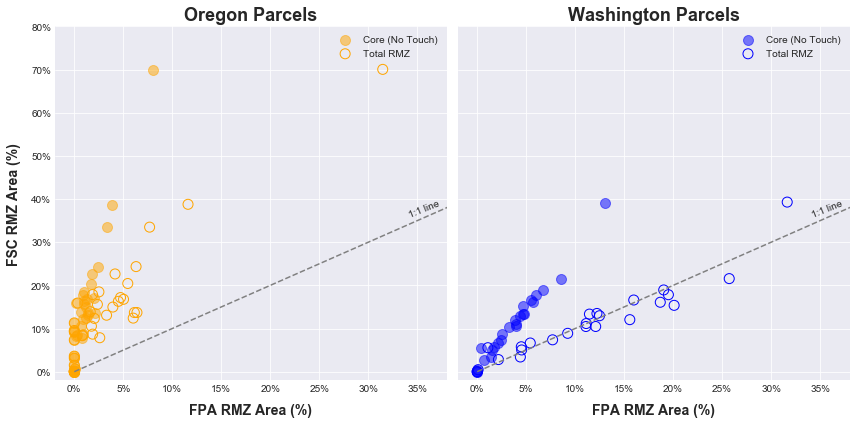

In [8]:
fig, axs = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

# plot the scatter for Oregon core and total riparian areas
parcels.loc[parcels.state == 'OR'].plot.scatter(x='pctcore_bau', y='pctcore_fsc', s=100, alpha=0.5,
                                                ax=axs[0], label='Core (No Touch)', color='orange', )
parcels.loc[parcels.state == 'OR'].plot.scatter(x='pctrip_bau', y='pctrip_fsc', s=100,
                                               ax=axs[0], label='Total RMZ', c='none', edgecolors='orange')
axs[0].set_title('Oregon Parcels', weight='bold', fontsize=18)

# plot the scatter for Oregon core and total riparian areas
parcels.loc[parcels.state == 'WA'].plot.scatter(x='pctcore_bau', y='pctcore_fsc', s=100, alpha=0.5,
                                                ax=axs[1], label='Core (No Touch)', color='blue')
parcels.loc[parcels.state == 'WA'].plot.scatter(x='pctrip_bau', y='pctrip_fsc', s=100, 
                                               ax=axs[1], label='Total RMZ', c='none', edgecolors='blue')
axs[1].set_title('Washington Parcels', weight='bold', fontsize=18)

# label and format the x- and y- axes
for ax in axs:
    ax.set_ylabel('FSC RMZ Area (%)', weight='bold', labelpad=10, fontsize=14)
    ax.set_xlabel('FPA RMZ Area (%)', weight='bold', labelpad=10, fontsize=14)
    ax.set_xlim(-0.02,0.38)
    ax.set_ylim(-0.02,0.8)
    ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    ax.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    ax.legend(loc='upper right')
    
    # create and plot a 1:1 line
    ax.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='gray', linestyle='--')
    ax.text(0.34,0.385, '1:1 line', rotation=22)

plt.tight_layout()
plt.savefig('./images/FSCvFPA_RMZarea.png');

## Gather simulated outcomes for all the parcels
The output from FVS for each stand provides per-acre estimates for all the metrics we're interested. Utilizing the area of each stand that should be subjected to various management constraints, we generated "area-expanded" values at the parcel-level by multiplying the per-acre values for each stand by the area that each silvicultural prescription (i.e., each separate FVS simulation) should represent.

These expanded values are summarized for a range of alternative scenarios, including the four primary scenarios described in the article (BAU, SHORT~FSC, LONG~FPA, and LONG~FSC), as well as a variety of other scenarios utilized to isolate the effects of the greater green tree retention and riparian buffer expansion required under FSC:
* **FPA_FSC:** SHORT~FPA (FPA retention, 38-44 yr rotation) with FSC riparian buffers added
* **FPAlong_FSC:** LONG~FPA (FPA retention, 75 yr rotation) with FSC riparian buffers added
* **FSC_FPA:** SHORT~FSC (30% retention, 38-44 yr rotation) with FPA riparian buffers
* **FSClong_FPA:** LONG~FSC (10% retention, 75 yr rotation) with FPA riparian buffers  

These data were gathered from the `rxall` table we created in the FVSOut PostgreSQL database used in the simulations described in the article with the following SQL query:
```
SELECT *
FROM rxall
WHERE parcel NOT IN (26, 31, 39);
```

Parcel #s 26, 31, and 39 were properties originally selected for simulations, but which did not contain forest inventory data in the GNN database.

The results of this query were exported from the database to a comma-delimited file: `rxall.csv`.

In [9]:
data = pd.read_csv('./data/rxall.csv')

In [10]:
# join with the parcel table to get the state for each parcel
data = pd.merge(left=data, right=parcels[['parcelid', 'state']], left_on='parcel', right_on='parcelid').drop('parcelid', axis=1)
data = data.sort_values(by=['parcel', 'rx', 'year'])

# rename some of the scenarios to intuitive names
data['scenario'] = data.rx.replace(to_replace={'BAU':'BAU', 'FSC':'SHORT~FSC', 'BAU_long':'LONG~FPA', 'FSC_long':'LONG~FSC'})

In [11]:
# calculate carbon stored in trees
data['tree_carbon'] = data.aboveground_total_live + data.belowground_live + data.standing_dead 

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10240 entries, 0 to 10219
Data columns (total 36 columns):
parcel                       10240 non-null int64
year                         10240 non-null int64
cumulative_mbf               10240 non-null float64
aboveground_total_live       10240 non-null float64
aboveground_merch_live       10240 non-null float64
belowground_live             10240 non-null float64
standing_dead                10240 non-null float64
forest_down_dead_wood        10240 non-null float64
forest_floor                 10240 non-null float64
forest_shrub_herb            10240 non-null float64
total_stand_carbon           10240 non-null float64
total_removed_carbon         10240 non-null float64
carbon_released_from_fire    10240 non-null float64
products                     10240 non-null float64
landfill                     10240 non-null float64
energy                       10240 non-null float64
emissions                    10240 non-null float64
merch_carbo

### Implementing California Air Resources Board accounting for harvest wood products.

We will folllow the California ARB accounting approach for carbon storage in wood products. 

The 2015 California ARB [Forest Carbon Offset Project Protocol](https://www.arb.ca.gov/cc/capandtrade/protocols/usforest/usforestprojects_2015.htm) accounts for carbon stored in products by defining the disposition of removed marchantable carbon into the products pool over time.

In the Western Cascades "Assessment Area", the ARB protocol specifies the following factors:

| Description | Softwood Lumber | Hardwood Lumber | Plywood | Oriented Strand Board | Non-structural Panels | Miscellaneous | Paper |
|---|---|---|---|---|---|---|---|
| % in each class | 75.3% | 4.3% | 11.4% | 0.0% | 0.1% | 0.5% | 8.4% |
| 100-yr avg. storage | 46.3% | 25.0% | 48.4% | 58.2% | 38.0% | 17.6% | 5.8% |
| avg. storage in in-use products | 34.9% | 1.1% | 5.5% | 0.0% | 0.0% | 0.1% | 0.5% |

The sum of merchantable carbon removed that remains across product categories (averaged over 100 years) is __42.1%__. We will apply this proportion to the volume of carbon in the merchantable portions of trees removed over time.

In [13]:
data['ARBhwp'] = data.merch_carbon_removed * 0.421

### Implementing California Air Resources Board accounting for market effects leakage.

We will folllow the California ARB accounting approach to account for the displacement of harvesting outside the "project area". 

The 2015 California ARB [Forest Carbon Offset Project Protocol](https://www.arb.ca.gov/cc/capandtrade/protocols/usforest/usforestprojects_2015.htm) describes market leakage as "Secondary Effects Emissions," which is calculated as:

If $\sum\limits_{n=1}^{y} AC_{se,n} - BC_{se,n} >= 0 $: then  $SE_y = 0$

If $\sum\limits_{n=1}^{y} AC_{se,n} - BC_{se,n} < 0 $: then $SE_y = (AC_y - BC_y) * 0.20 $

Where,<br>
$SE_y$ = Estimated annual secondary effects (MT $CO_2e$)<br>
$y$ = The reporting period<br>
$AC_{se,n}$ = Actual amount of carbon in standing live and standing dead trees (whole tree including belowground biomass and bark) harvested by reporting period $y$<br>
$BC_{se,n}$ = Estimated average baseline amount of carbon in standing live and standing dead trees (whole tree including belowground biomass and bark) that would have been harvested by reporting period $y$



In [14]:
# FVS outputs total_removed_carbon in the FVS_Carbon report as the amount of above-ground carbon removed each period
# To follow the ARB requirement to also account for belowground carbon in harvested trees, we'll need to update the FVS output

# the ratio of amount of "tree carbon" (above- and below-ground live + standing dead) to above-ground tree carbon
ratio = data.tree_carbon/(data.aboveground_total_live + data.standing_dead)

data['periodic_removed_carbon_alltree'] = data.total_removed_carbon * ratio

# now calculate the cumulative amount of total removed carbon
cols = ['parcel', 'rx', 'year', 'periodic_removed_carbon_alltree']
data['cumulative_removed_carbon_alltree'] = data[cols].groupby(by=['parcel', 'rx']).cumsum()['periodic_removed_carbon_alltree']

In [15]:
def calc_leakage(row):
    '''
    For each row in the data, looks up the amount of harvested carbon under the BAU scenario 
    for the same parcel and year, and then calculates market effects leakage per the ARB protocol.
    '''
    bau_mask = (data.rx == 'BAU') & (data.year == row.year) & (data.parcel == row.parcel)
    bau_removed = data.loc[bau_mask, 'periodic_removed_carbon_alltree'].values[0]
    bau_cum_removed = data.loc[bau_mask, 'cumulative_removed_carbon_alltree'].values[0]
    
    if row.cumulative_removed_carbon_alltree < bau_cum_removed :
        leakage = (row.periodic_removed_carbon_alltree - bau_removed) * 0.20
    
    else:
        leakage = 0
        
    return leakage

In [16]:
# calculate the periodic leakage in each 5-year simulation cycle
data['leakage'] = data[['parcel', 'rx', 'year', 'periodic_removed_carbon_alltree', 'cumulative_removed_carbon_alltree']].apply(calc_leakage, axis=1)

# calculate the cumulative market effects leakage over the 100-year simulation timeframe
cols = ['parcel', 'rx', 'year', 'leakage']
data['cumulative_leakage'] = data[cols].groupby(by=['parcel', 'rx']).cumsum()['leakage']

In [17]:
# calculate carbon stored in the forest and in wood products
data['tree_carbon'] = data.aboveground_total_live + data.belowground_live + data.standing_dead 
data['tot_carbon'] = data.aboveground_total_live + data.belowground_live + data.standing_dead + data.ARBhwp + data.leakage
data['tCO2e'] = data.tot_carbon * 44/12

In [18]:
# calculate cumulative volume removals and total standing + removed volumes
vol_cols = ['rbdft', 'rcuft', 'rmcuft']
cum_removals = data.groupby(by=['parcel', 'rx', 'year']).sum().groupby(level=[0,1])[vol_cols].cumsum()
data.set_index(['parcel', 'rx', 'year'], inplace=True)
data['cumulative_rbdft'] = cum_removals['rbdft']
data['cumulative_rcuft'] = cum_removals['rcuft']
data['cumulative_rmcuft'] = cum_removals['rmcuft']
data.reset_index(inplace=True)
data['stand_plus_remove_MBF'] = (data.bdft + data.cumulative_rbdft)/1000.
data['stand_plus_remove_cuft_CCF'] = (data.tcuft + data.cumulative_rcuft)/100.
data['stand_plus_remove_mcuft_CCF'] = (data.mcuft + data.cumulative_rmcuft)/100.

## Convert values to per-hectare
We conducted FVS simulations using acres, convert the fields we're interested in to hectares.

In [19]:
data_cols = ['cumulative_mbf', 'aboveground_total_live', 'aboveground_merch_live', 'belowground_live', 
             'standing_dead', 'forest_down_dead_wood', 'forest_floor', 'forest_shrub_herb',
             'total_stand_carbon', 'total_removed_carbon', 'carbon_released_from_fire', 
             'products', 'landfill', 'energy', 'emissions', 'merch_carbon_stored', 
             'merch_carbon_removed', 'tcuft', 'mcuft', 'rcuft', 'rmcuft', 'bdft', 'rbdft', 'npv_adj', 'nfv_adj',
             'undiscounted_cost_adj', 'discounted_cost_adj', 'undiscounted_revenue_adj', 'discounted_revenue_adj',
             'mrch_boardfoot_volume_adj', 'tree_carbon', 'ARBhwp', 'periodic_removed_carbon_alltree',
             'cumulative_removed_carbon_alltree', 'leakage', 'cumulative_leakage', 'tot_carbon', 'tCO2e', 
             'cumulative_rbdft', 'cumulative_rcuft', 'cumulative_rmcuft', 'stand_plus_remove_MBF',
             'stand_plus_remove_cuft_CCF', 'stand_plus_remove_mcuft_CCF']
data[data_cols] = data[data_cols] * 2.47105

## Visualize the carbon storage in the forest, wood products, and emissions from leakage  
We will graph the carbon storage per acre for all the simulated parcels in each of these primary carbon pools/emissions sources under the four primary scenarios we're interested in.

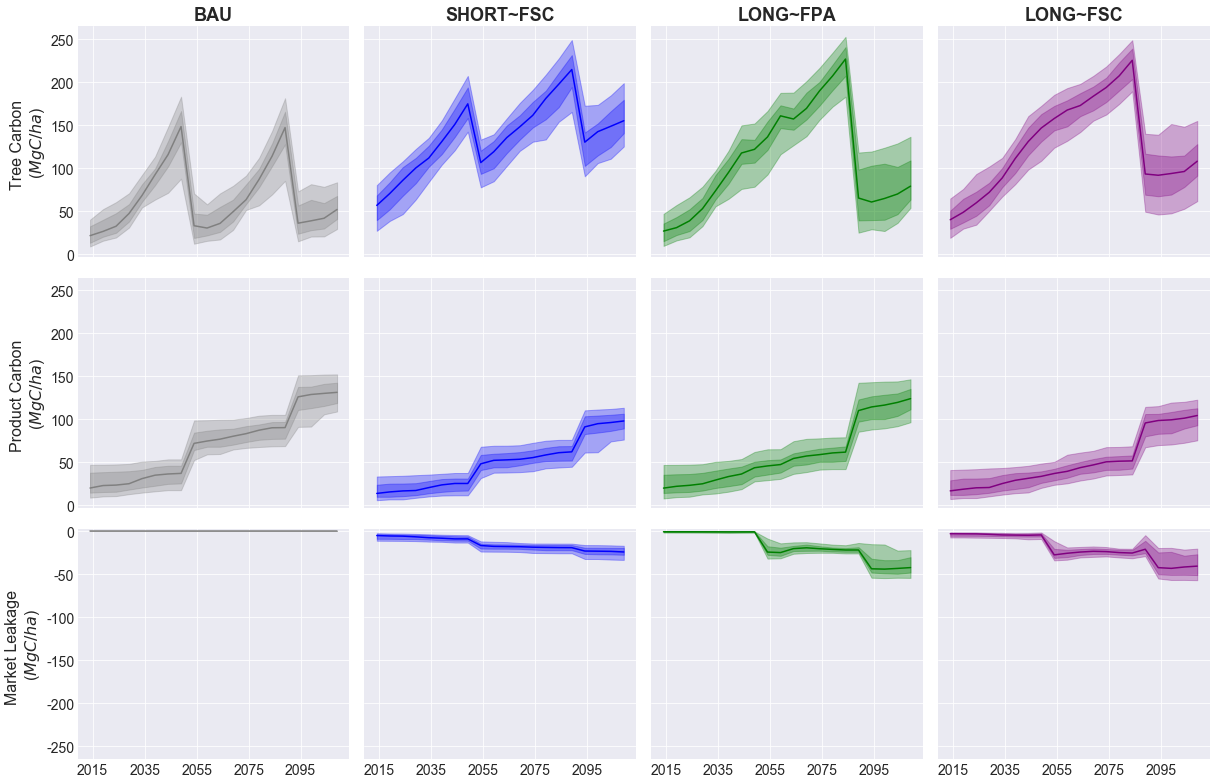

In [67]:
colors = ['gray', 'blue', 'green', 'purple']
pal = colors # color palette

fig, axs = plt.subplots(3,4, figsize=(17,11), sharex=True, sharey='row')
# data columns we're interested in graphing
cols = ['parcel', 'year', 'scenario', 'tree_carbon', 'ARBhwp', 'cumulative_leakage']
metrics = ['tree_carbon', 'ARBhwp', 'cumulative_leakage']
scenarios = ['BAU', 'SHORT~FSC', 'LONG~FPA', 'LONG~FSC']
yaxis_labels = ['''Tree Carbon 
($MgC/ha$)''',
                '''Product Carbon 
($MgC/ha$)''',
                '''Market Leakage 
($MgC/ha$)''']

i=0
for metric in metrics:
    graph_parcels = data[cols].sort_values(by=['parcel', 'year']).groupby(by=['scenario','year']).quantile([0, 0.10,0.25,0.50,0.75,0.90, 1.0])[metric].unstack(level=-1)
    pivot = pd.pivot_table(graph_parcels.reset_index(), index='year', columns='scenario', values=[0,0.10,0.25,0.50,0.75,0.90,1])
    pivot = pivot.sort_index(axis=1, ascending=False)
    axs[i][0].set_ylabel(metric, fontsize=14) # label y-axis on first graph
    
    # plot the percentile bands
    for j in range(len(scenarios)):
        # 10th and 90th percentile range
        axs[i][j].fill_between(x=pivot.index, 
                              y1=pivot[0.10][scenarios[j]], 
                              y2=pivot[0.90][scenarios[j]],
                              alpha=0.3, color=pal[j])
        # 25th and 75th percentile range
        axs[i][j].fill_between(x=pivot.index, 
                              y1=pivot[0.25][scenarios[j]], 
                              y2=pivot[0.75][scenarios[j]],
                              alpha=0.3, color=pal[j])
        # median line
        axs[i][j].plot(pivot[0.5][scenarios[j]], lw=1.5, color=pal[j])    
    i+=1

# label the plots
for i in range(len(axs[0])):
    axs[0][i].set_title(scenarios[i], fontsize=18, weight='bold') # label title on top row
    axs[-1][i].xaxis.set_tick_params(labelsize=14) # ticks on bottom row

for i in range(len(axs)):
    axs[i][0].set_ylabel(yaxis_labels[i], fontsize=16) # axis label on first column
    axs[i][0].yaxis.set_major_formatter(FuncFormatter('{0:,.0f}'.format))
    axs[i][0].yaxis.set_tick_params(labelsize=14)
    #axs[i][0].set_ylim(-5, 125)
                               
# set all graphs to share the same axes as tree carbon
tree_min, tree_max = axs[0][0].get_ylim() 
axs[1][0].set_ylim(tree_min, tree_max)
axs[2][0].set_ylim(-tree_max, -tree_min)
plt.setp(axs, xticks=range(2015,2115,20))

plt.tight_layout()
plt.savefig('./images/carbon_pools.png');

## Visualize the evolution of the Key Performance Indicators
We will graph the credited carbon storage, timber output, and discounted cash flow for all the simulated parcels in each of these primary carbon pools/emissions sources under the four primary scenarios we're interested in.

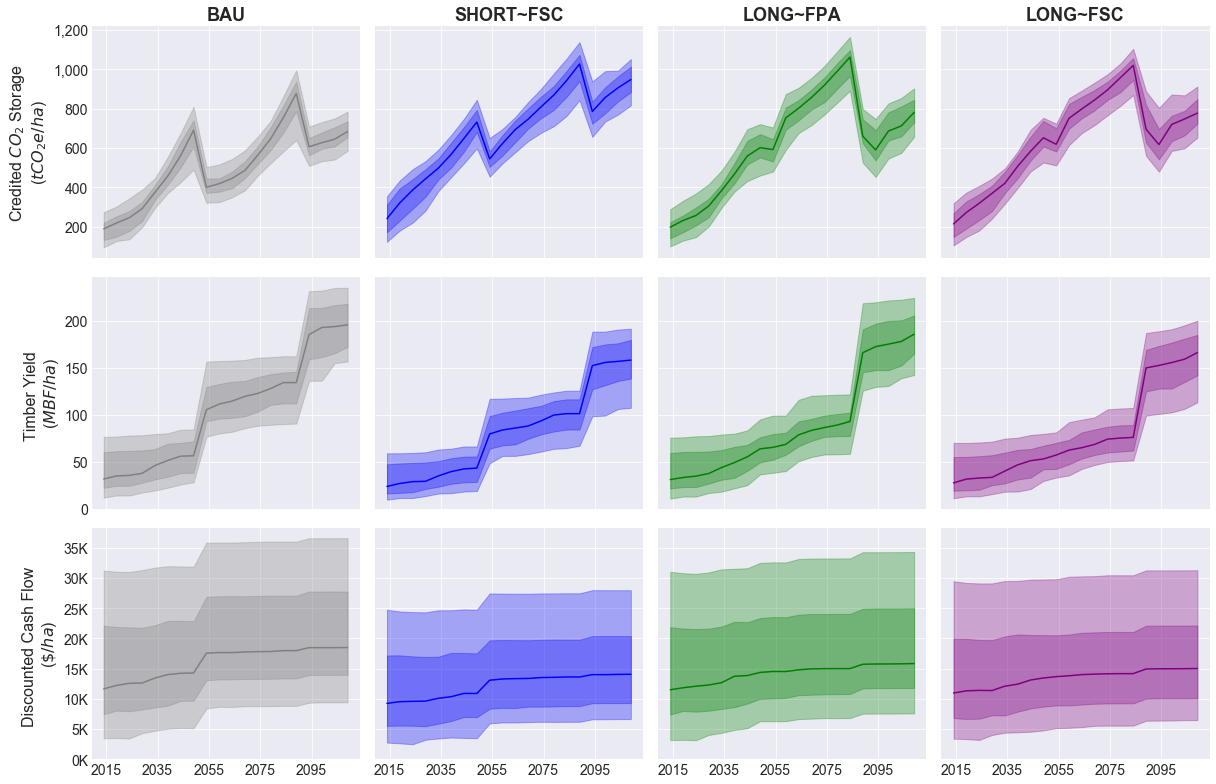

In [21]:
colors = ['gray', 'blue', 'green', 'purple']
pal = colors # color palette

fig, axs = plt.subplots(3,4, figsize=(17,11), sharex=True, sharey='row')
cols = ['parcel', 'year', 'scenario', 'tCO2e', 'cumulative_mbf', 'npv_adj']
metrics = ['tCO2e', 'cumulative_mbf', 'npv_adj']
scenarios = ['BAU', 'SHORT~FSC', 'LONG~FPA', 'LONG~FSC']
yaxis_labels = ['''Credited $CO_2$ Storage 
($tCO_2e/ha$)''', 
                '''Timber Yield 
($MBF/ha$)''',
                '''Discounted Cash Flow 
($\$/ha$)''']

i=0
for metric in metrics:
    graph_parcels = data[cols].sort_values(by=['parcel', 'year']).groupby(by=['scenario','year']).quantile([0, 0.10,0.25,0.50,0.75,0.90, 1.0])[metric].unstack(level=-1)
    pivot = pd.pivot_table(graph_parcels.reset_index(), index='year', columns='scenario', values=[0,0.10,0.25,0.50,0.75,0.90,1])
    pivot = pivot.sort_index(axis=1, ascending=False)
    axs[i][0].set_ylabel(metric, fontsize=14) # label y-axis on first graph
    
    # plot the percentile bands
    for j in range(len(scenarios)):
        # 10th and 90th percentile range
        axs[i][j].fill_between(x=pivot.index, 
                              y1=pivot[0.10][scenarios[j]], 
                              y2=pivot[0.90][scenarios[j]],
                              alpha=0.3, color=pal[j])
        # 25th and 75th percentile range
        axs[i][j].fill_between(x=pivot.index, # 
                              y1=pivot[0.25][scenarios[j]], 
                              y2=pivot[0.75][scenarios[j]],
                              alpha=0.3, color=pal[j])
        # median line
        axs[i][j].plot(pivot[0.5][scenarios[j]], lw=1.5, color=pal[j])    
    i+=1

# label the plots
for i in range(len(axs[0])): # go by rows
    axs[0][i].set_title(scenarios[i], fontsize=18, weight='bold') # label title on top row
    axs[-1][i].xaxis.set_tick_params(labelsize=14) # ticks on bottom row

for i in range(len(axs)): # go by columns
    axs[i][0].set_ylabel(yaxis_labels[i], fontsize=16) # axis label on first column
    axs[i][0].yaxis.set_major_formatter(FuncFormatter('{0:,.0f}'.format))
    axs[i][0].yaxis.set_tick_params(labelsize=14)
    
# adjust axes limits and ticks for aesthetics
plt.setp(axs, xticks=range(2015,2115,20))

axs[1][0].set_ylim(0, None)
axs[2][0].set_ylim(0, None)
#plt.setp(axs[0], yticks=range(0,500,100)) # credited tco2e yticks
#plt.setp(axs[1], yticks=range(0,120,20)) # timber yield yticks
#plt.setp(axs[2], yticks=range(0,17500,2500), xlabel='') # cash flow yticks
# format the currency axis
def currency(x, pos):
    return '{:1.0f}K'.format(x*1e-3)
axs[-1][0].yaxis.set_major_formatter(FuncFormatter(currency))
                               
plt.tight_layout()
plt.savefig('./images/KPI_lines.png');

## Calculate the Key Performance Indicators
We calculate the ending value of each Key Performance Indicator (KPI), as well as a few extra (e.g., standing plus removed timber) for each parcel and scenario. We do this both in absolute terms, as well as in relative terms (% difference vs. BAU).

The KPIs for timber output and discounted cash flow are the amount accumulated by the end of the simulation. The KPI for carbon storage is the average amount of carbon stored in the credited pools and emissions sources over the course of the simulation.

In [22]:
cols = ['parcel', 'year', 'state', 'scenario', 'cumulative_mbf', 
        'tCO2e', 'npv_adj', 'stand_plus_remove_MBF', 'stand_plus_remove_mcuft_CCF']

all_rx = data[cols].sort_values(by=['parcel', 'year']).groupby(by=['scenario','parcel','state']).agg({'cumulative_mbf':'max', 'tCO2e':'mean', 
                                                                                                      'npv_adj':'max', 
                                                                                                      'stand_plus_remove_MBF':'max',
                                                                                                     'stand_plus_remove_mcuft_CCF':'max'})
all_rx['tCO2e_MBF'] = all_rx.tCO2e / all_rx.cumulative_mbf

In [23]:
# calculate the relative difference with BAU in both absolute terms...
long_fpa = all_rx.xs('LONG~FPA') - all_rx.xs('BAU')
long_fsc = all_rx.xs('LONG~FSC') - all_rx.xs('BAU')
short_fsc = all_rx.xs('SHORT~FSC') - all_rx.xs('BAU')

# ... and percent change terms
long_fpa_pct = (all_rx.xs('LONG~FPA') - all_rx.xs('BAU'))/all_rx.xs('BAU')
long_fsc_pct = (all_rx.xs('LONG~FSC') - all_rx.xs('BAU'))/all_rx.xs('BAU')
short_fsc_pct = (all_rx.xs('SHORT~FSC') - all_rx.xs('BAU'))/all_rx.xs('BAU')

## Visualize the absolute changes in KPIs between scenarios and BAU
These scatter plots will display the values of absolute changes in the KPIs for each parcel.

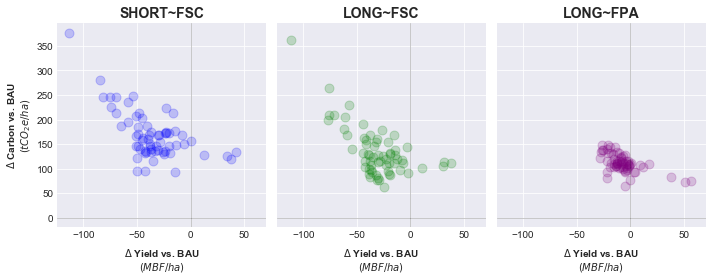

In [24]:
fig, axs = plt.subplots(1,3, figsize=(10,4), sharey=True, sharex=True)
scenarios = [short_fsc, long_fsc, long_fpa]
colors = ['blue', 'green', 'purple']
titles = ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']
for i in range(3):
    axs[i].axvline(x=0, color='black', lw=1, alpha=0.2)
    axs[i].axhline(y=0, color='black', lw=1, alpha=0.2)
    scenarios[i].plot.scatter(x='cumulative_mbf', y='tCO2e', 
                              ax=axs[i], color=colors[i], alpha=0.2, s=80)

    axs[i].set_xlabel('''$\Delta$ Yield vs. BAU
$(MBF/ha)$''', weight='bold', labelpad=8)
    axs[i].set_title(titles[i], fontsize=14, weight='bold')

axs[0].set_ylabel('''$\Delta$ Carbon vs. BAU
$(tCO_2e/ha)$''', weight='bold')

plt.tight_layout()
plt.savefig('./images/scenario_scatter_carbontimber.png');

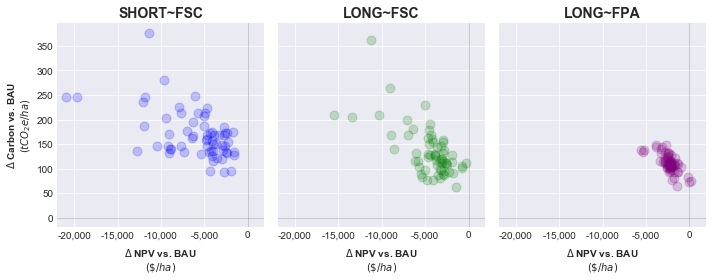

In [25]:
fig, axs = plt.subplots(1,3, figsize=(10,4), sharey=True, sharex=True)
scenarios = [short_fsc, long_fsc, long_fpa]
colors = ['blue', 'green', 'purple']
titles = ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']
for i in range(3):
    axs[i].axvline(x=0, color='black', lw=1, alpha=0.2)
    axs[i].axhline(y=0, color='black', lw=1, alpha=0.2)
    scenarios[i].plot.scatter(x='npv_adj', y='tCO2e', 
                              ax=axs[i], color=colors[i], alpha=0.2, s=80)
    axs[i].xaxis.set_major_formatter(FuncFormatter('{:,.0f}'.format))

    axs[i].set_xlabel('''$\Delta$ NPV vs. BAU
$(\$/ha)$''', weight='bold', labelpad=8)
    axs[i].set_title(titles[i], fontsize=14, weight='bold')
#axs[0].set_ylim(-5,200)
#axs[0].set_xlim(-5500,500)
axs[0].set_ylabel('''$\Delta$ Carbon vs. BAU
$(tCO_2e/ha)$''', weight='bold')
plt.tight_layout()
plt.savefig('./images/scenario_scatter_carboncash.png');

## Visualize the relative changes in KPIs between scenarios and BAU
These scatter plots will display the values of percent changes in the KPIs for each parcel relative to BAU.

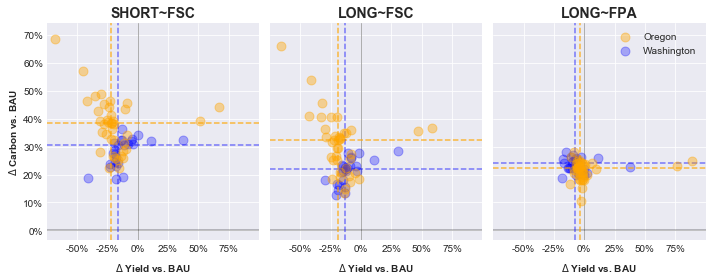

In [26]:
fig, axs = plt.subplots(1,3, figsize=(10,4), sharey=True, sharex=True)
scenarios = [short_fsc_pct, long_fsc_pct, long_fpa_pct]
colors = ['blue', 'green', 'purple']
titles = ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']
for i in range(3):
    # add some zero-lines
    axs[i].axvline(x=0, color='black', lw=1, alpha=0.3, zorder=1)
    axs[i].axhline(y=0, color='black', lw=1.5, alpha=0.3, zorder=1)
    
    # plot the parcel-level values for Oregon and Washington
    scenarios[i].loc(axis=0)[:,'OR'].plot.scatter(x='cumulative_mbf', y='tCO2e', 
                              ax=axs[i], color='orange', alpha=0.4, s=80, label='Oregon', zorder=3)
    scenarios[i].loc(axis=0)[:,'WA'].plot.scatter(x='cumulative_mbf', y='tCO2e', 
                              ax=axs[i], color='blue', alpha=0.3, s=80, label='Washington', zorder=2)

    # add some lines to indicate mean values
    axs[i].axvline(x=scenarios[i].loc(axis=0)[:,'OR'].cumulative_mbf.median(), color='orange', lw=1.5, ls='--', alpha=0.75)
    axs[i].axhline(y=scenarios[i].loc(axis=0)[:,'OR'].tCO2e.median(), color='orange', lw=1.5, ls='--', alpha=0.75)
    axs[i].axvline(x=scenarios[i].loc(axis=0)[:,'WA'].cumulative_mbf.median(), color='blue', lw=1.5, ls='--', alpha=0.5)
    axs[i].axhline(y=scenarios[i].loc(axis=0)[:,'WA'].tCO2e.median(), color='blue', lw=1.5, ls='--', alpha=0.5)
    
    # format the x-axis
    axs[i].set_xlabel('$\Delta$ Yield vs. BAU', weight='bold', labelpad=8)
    axs[i].xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    
    # add scenario titles
    axs[i].set_title(titles[i], fontsize=14, weight='bold')


# format the axes on the first subplot, will ripple to other subplots
axs[0].set_xlim(-0.75,1)
axs[0].set_xticks(np.linspace(-0.5,0.75,6))
# axs[0].set_ylim(None,1)
# axs[0].set_yticks(np.linspace(-0,1.0,5))
axs[0].yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
axs[0].set_ylabel('$\Delta$ Carbon vs. BAU', weight='bold')

# show the legend on the last subplot
axs[0].legend_.remove()
axs[1].legend_.remove()
axs[2].legend()

plt.tight_layout()
plt.savefig('./images/scenario_scatter_carbontimber_percent.png');

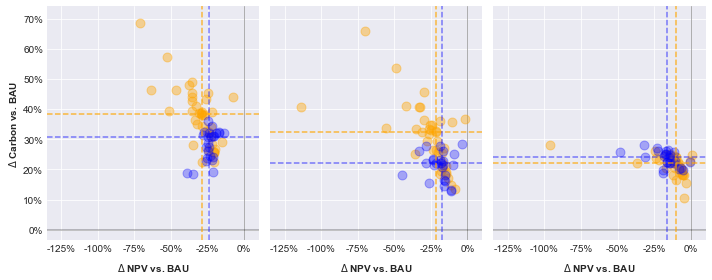

In [27]:
fig, axs = plt.subplots(1,3, figsize=(10,4), sharey=True, sharex=True)
scenarios = [short_fsc_pct, long_fsc_pct, long_fpa_pct]
titles = ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']
colors = ['blue', 'green', 'purple']
for i in range(3):
    # add some zero-lines
    axs[i].axvline(x=0, color='black', lw=1, alpha=0.3, zorder=1)
    axs[i].axhline(y=0, color='black', lw=1.5, alpha=0.3, zorder=1)
    
    scenarios[i].loc(axis=0)[:,'OR'].plot.scatter(x='npv_adj', y='tCO2e', 
                                                  ax=axs[i], color='orange', alpha=0.4, 
                                                  s=80, zorder=2)
    scenarios[i].loc(axis=0)[:,'WA'].plot.scatter(x='npv_adj', y='tCO2e',
                                                  ax=axs[i], color='blue', alpha=0.3, s=80, 
                                                  zorder=2)
    
    # add some lines to indicate mean values
    axs[i].axvline(x=scenarios[i].loc(axis=0)[:,'OR'].npv_adj.median(), color='orange', lw=1.5, ls='--', alpha=0.75)
    axs[i].axhline(y=scenarios[i].loc(axis=0)[:,'OR'].tCO2e.median(), color='orange', lw=1.5, ls='--', alpha=0.75)
    axs[i].axvline(x=scenarios[i].loc(axis=0)[:,'WA'].npv_adj.median(), color='blue', lw=1.5, ls='--', alpha=0.5)
    axs[i].axhline(y=scenarios[i].loc(axis=0)[:,'WA'].tCO2e.median(), color='blue', lw=1.5, ls='--', alpha=0.5)
    
    
    
    axs[i].set_xlabel('$\Delta$ NPV vs. BAU', weight='bold', labelpad=8)
    axs[i].xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
#     axs[i].set_title(titles[i], fontsize=14, weight='bold')

axs[0].yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))

# axs[0].set_ylim(-1,1)
# axs[0].set_yticks(np.linspace(-0.75,0.75,7))

axs[0].set_xlim(-1.35,None)
# axs[0].set_xticks(np.linspace(-0.75,0.75,7))

axs[0].set_ylabel('$\Delta$ Carbon vs. BAU', weight='bold')
plt.tight_layout()
plt.savefig('./images/scenario_scatter_carboncash_percent.png');

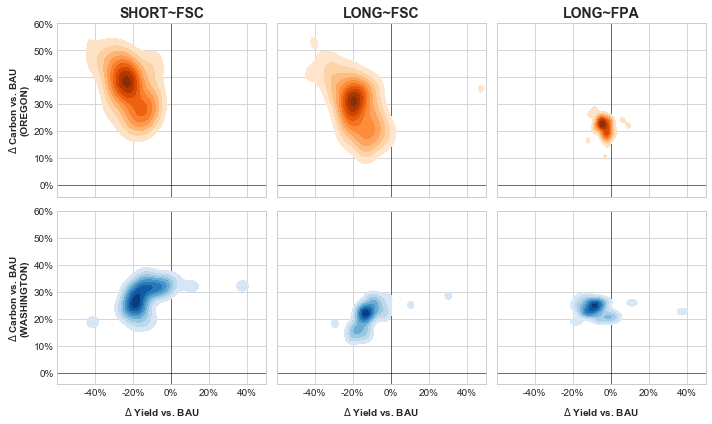

In [28]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(2,3, figsize=(10,6), sharey=True, sharex=True)
    scenarios = [short_fsc_pct, long_fsc_pct, long_fpa_pct]
    titles = ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']
    colors = ['blue', 'green', 'purple']
    for i in range(3):
        axs[0][i].axvline(x=0, color='black', lw=1, alpha=0.5, zorder=1)
        axs[0][i].axhline(y=0, color='black', lw=1, alpha=0.5, zorder=1)
        axs[1][i].axvline(x=0, color='black', lw=1, alpha=0.5, zorder=1)
        axs[1][i].axhline(y=0, color='black', lw=1, alpha=0.5, zorder=1)

        axs[0][i] = sns.kdeplot(data=scenarios[i].loc(axis=0)[:,'OR'].cumulative_mbf, 
                                data2=scenarios[i].loc(axis=0)[:,'OR'].tCO2e,
                                shade=True, ax=axs[0][i], cmap="Oranges", 
                                shade_lowest=False, n_levels=10, zorder=2)
        axs[1][i] = sns.kdeplot(data=scenarios[i].loc(axis=0)[:,'WA'].cumulative_mbf, 
                                data2=scenarios[i].loc(axis=0)[:,'WA'].tCO2e,
                                shade=True, ax=axs[1][i], cmap="Blues", 
                                shade_lowest=False, n_levels=10, zorder=2)


        axs[0][i].set_xlabel('')
        axs[1][i].set_xlabel('$\Delta$ Yield vs. BAU', weight='bold', labelpad=8)
        axs[0][i].xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
        axs[0][i].set_ylabel('')
        axs[1][i].set_ylabel('')
        axs[0][i].set_title(titles[i], fontsize=14, weight='bold')

    axs[0][0].yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))

    axs[0][0].set_ylim(None,0.6)
    # axs[0][0].set_yticks(np.linspace(-0.75,0.75,7))
    axs[0][0].set_xlim(-0.6,0.5)
    axs[0][0].set_xticks(np.linspace(-0.4,0.4,5))


    axs[0][0].set_ylabel('''$\Delta$ Carbon vs. BAU
(OREGON)''', weight='bold')
    axs[1][0].set_ylabel('''$\Delta$ Carbon vs. BAU
(WASHINGTON)''', weight='bold')

    plt.tight_layout()
    plt.savefig('./images/scenario_scatter_carbonyield_percent_kde.png');

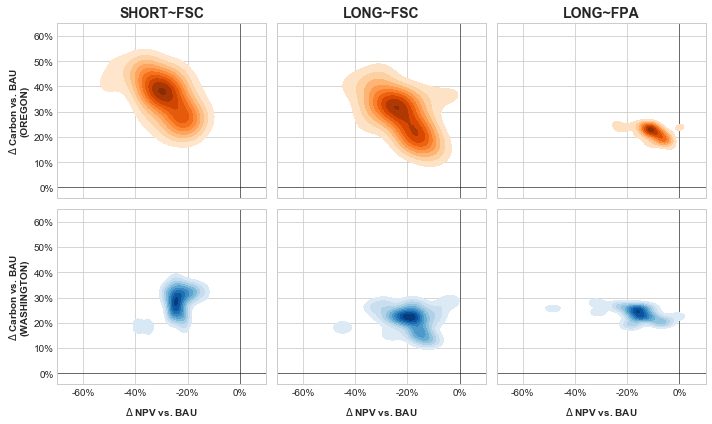

In [29]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(2,3, figsize=(10,6), sharey=True, sharex=True)
    scenarios = [short_fsc_pct, long_fsc_pct, long_fpa_pct]
    titles = ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']
    colors = ['blue', 'green', 'purple']
    for i in range(3):
        axs[0][i].axvline(x=0, color='black', lw=1, alpha=0.5, zorder=1)
        axs[0][i].axhline(y=0, color='black', lw=1, alpha=0.5, zorder=1)
        axs[1][i].axvline(x=0, color='black', lw=1, alpha=0.5, zorder=1)
        axs[1][i].axhline(y=0, color='black', lw=1, alpha=0.5, zorder=1)

        axs[0][i] = sns.kdeplot(data=scenarios[i].loc(axis=0)[:,'OR'].npv_adj, 
                                data2=scenarios[i].loc(axis=0)[:,'OR'].tCO2e,
                                shade=True, ax=axs[0][i], cmap="Oranges", 
                                shade_lowest=False, n_levels=10, zorder=2)
        axs[1][i] = sns.kdeplot(data=scenarios[i].loc(axis=0)[:,'WA'].npv_adj, 
                                data2=scenarios[i].loc(axis=0)[:,'WA'].tCO2e,
                                shade=True, ax=axs[1][i], cmap="Blues", 
                                shade_lowest=False, n_levels=10, zorder=2)


        axs[0][i].set_xlabel('')
        axs[1][i].set_xlabel('$\Delta$ NPV vs. BAU', weight='bold', labelpad=8)
        axs[0][i].xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
        axs[0][i].set_ylabel('')
        axs[1][i].set_ylabel('')
        axs[0][i].set_title(titles[i], fontsize=14, weight='bold')

    axs[0][0].yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))

    axs[0][0].set_ylim(None,0.65)
#     # axs[0][0].set_yticks(np.linspace(-0.75,0.75,7))
    axs[0][0].set_xlim(-0.7,0.1)
#     axs[0][0].set_xticks(np.linspace(-0.4,0.4,5))


    axs[0][0].set_ylabel('''$\Delta$ Carbon vs. BAU
(OREGON)''', weight='bold')
    axs[1][0].set_ylabel('''$\Delta$ Carbon vs. BAU
(WASHINGTON)''', weight='bold')

    plt.tight_layout()
    plt.savefig('./images/scenario_scatter_carboncash_percent_kde.png');

## Generate tables for the absolute changes in KPIs between scenarios and BAU
These tables capture metrics for the central tendency and spread of the KPIs for each scenario.

In [30]:
# formatting for the tables
styles = {'cumulative_mbf':'{:,.1f}', 
          'npv_adj':'${:,.0f}', 
          'tCO2e': '{:,.0f}', 
          'tCO2e_MBF':'{:.2f}', 
          'stand_plus_remove_MBF': '{:,.1f}', 
          'stand_plus_remove_mcuft_CCF':'{:,.1f}'}

In [31]:
quantiles = [0, 0.1, 0.25, 0.5, 0.75, 0.90, 1.0]

In [32]:
# ignoring state differences
all_rx.reset_index().groupby(by=['scenario']).quantile(quantiles).drop('parcel', axis=1).style.format(styles)

In [33]:
# with values broken out by state as well
all_rx.reset_index().groupby(by=['state', 'scenario']).quantile(quantiles).drop('parcel', axis=1).style.format(styles)

In [56]:
# with values broken out by state as well, median only
all_rx.reset_index().groupby(by=['state', 'scenario']).quantile([0.5]).drop('parcel', axis=1).style.format(styles)

In [66]:
# ignore state differences
all_rx.reset_index().groupby(by=['scenario']).quantile([0.5]).drop('parcel', axis=1).style.format(styles)

,,cumulative_mbf,npv_adj,stand_plus_remove_MBF,stand_plus_remove_mcuft_CCF,tCO2e,tCO2e_MBF
scenario,,,,,,,
BAU,0.5,195.5,"$18,495",267.6,631.1,504,2.56
FPA_FSC,0.5,177.7,"$17,379",265.3,621.3,542,3.11
FPAlong_FSC,0.5,159.7,"$14,466",279.2,651.1,675,4.39
FSC_FPA,0.5,167.4,"$14,812",260.2,615.7,642,3.76
FSClong_FPA,0.5,180.1,"$15,700",276.7,652.3,601,3.40
LONG~FPA,0.5,185.6,"$15,839",288.4,676.0,621,3.26
LONG~FSC,0.5,166.0,"$15,019",267.3,617.5,637,3.88
SHORT~FSC,0.5,158.0,"$14,065",257.3,600.5,678,4.15


In [57]:
all_rx.reset_index().groupby(by=['state', 'scenario']).mean().drop('parcel', axis=1).style.format(styles)

## Generate tables for the relative changes in KPIs between scenarios and BAU
These tables capture metrics for the central tendency and spread of the KPIs for each scenario relative to BAU in both absolute and percent change terms.

#### LONG~FSC

In [34]:
long_fsc_pct.groupby(level=1).quantile(quantiles).style.format("{:.1%}")

In [35]:
# absolute difference between FSC-LONG and BAU
long_fsc.groupby(level=1).quantile(quantiles).style.format(styles)

In [70]:
# ignoring state differences
long_fsc_pct.quantile([0.25, 0.5, 0.75]).style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_adj,stand_plus_remove_MBF,stand_plus_remove_mcuft_CCF,tCO2e_MBF
0.25,-20.3%,20.7%,-27.9%,-3.9%,-4.9%,36.9%
0.5,-15.2%,25.5%,-20.6%,1.5%,-0.4%,43.5%
0.75,-9.7%,33.2%,-16.0%,6.9%,4.1%,63.0%


#### SHORT~FSC

In [37]:
short_fsc_pct.groupby(level=1).quantile(quantiles).style.format("{:.1%}")

In [38]:
# absolute difference between FSC-SHORT and BAU
short_fsc.groupby(level=1).quantile(quantiles).style.format(styles)

In [71]:
# ignoring state differences
short_fsc_pct.quantile([0.0, 0.25, 0.5, 0.75, 1.0]).style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_adj,stand_plus_remove_MBF,stand_plus_remove_mcuft_CCF,tCO2e_MBF
0.0,-68.0%,18.3%,-71.2%,-18.6%,-12.4%,-13.8%
0.25,-23.4%,27.2%,-32.5%,-7.0%,-7.3%,46.9%
0.5,-19.0%,32.4%,-25.3%,-4.0%,-4.7%,59.3%
0.75,-11.9%,39.0%,-22.1%,1.6%,-0.7%,83.0%
1.0,67.0%,68.5%,-7.6%,63.4%,15.6%,426.6%


#### LONG~FPA

In [40]:
long_fpa_pct.groupby(level=1).quantile(quantiles).style.format("{:.1%}")

In [41]:
# absolute difference between FPA-LONG and BAU
long_fpa.groupby(level=1).quantile(quantiles).style.format(styles)

In [69]:
# ignoring state differences
long_fpa_pct.quantile([0.25, 0.5, 0.75]).style.format("{:.1%}")

,cumulative_mbf,tCO2e,npv_adj,stand_plus_remove_MBF,stand_plus_remove_mcuft_CCF,tCO2e_MBF
0.25,-8.1%,20.5%,-16.8%,5.5%,5.4%,22.1%
0.5,-4.3%,22.5%,-11.7%,7.3%,7.9%,28.3%
0.75,-1.4%,24.5%,-8.0%,9.9%,8.9%,33.7%


## Timber Value Premium Analysis
We'll work through each parcel and identify the additional premium that would be required on timber sales to minimize the financial gap between each alternative scenario and BAU.

In [43]:
# a worker function to calculate the spread between an alternative scenario and BAU depending on a carbon value
def get_npv_diff(timber_premium, parcelid, scenario):
    '''
    Given a premium that is added to a scenario based on the timber revenue
    generated over time, calculates the (squared) difference in NPV 
    for a single parcel.
    '''
    cols = ['scenario', 'year', 'parcel', 'undiscounted_revenue_adj', 'undiscounted_cost_adj']
    # get the incremental undiscounted timber revenue and cost for each parcel over time
    parcel_temp = data[cols].loc[(data.scenario == scenario) & (data.parcel == parcelid)]
    bau_npv = data.loc[(data.scenario == 'BAU') & (data.parcel == parcelid)]['npv_adj'].iloc[-1]
    periodic = parcel_temp.groupby(by=['scenario', 'parcel']).diff()
    
    # correct the periodic income in the first year of the simulation, which was changed to NaN
    # by the diff function used above
    periodic['undiscounted_cost_adj'].iloc[0] = parcel_temp['undiscounted_cost_adj'].iloc[0]
    periodic['undiscounted_revenue_adj'].iloc[0] = parcel_temp['undiscounted_revenue_adj'].iloc[0]
    periodic['year'] = parcel_temp['year']

    # apply a premium value to the timber revenue for the alternative scenario
    periodic['undiscounted_premium'] = timber_premium * periodic.undiscounted_revenue_adj
    
    # then calculate cumulative NPV
    periodic['discounted_cost'] = periodic.undiscounted_cost_adj/((1+0.05)**(periodic.year-2014))
    periodic['discounted_revenue_premium'] = (periodic.undiscounted_premium + periodic.undiscounted_revenue_adj)/((1+0.05)**(periodic.year-2014))
    periodic['npv_premium'] = periodic.discounted_revenue_premium - periodic.discounted_cost
    # sum up the periodic net values to get cumulative NPV
    prem_npv = periodic.npv_premium.sum()
    
    # and finally calculates the NPV difference vs. BAU after 100 years for each property
    return (bau_npv - prem_npv)**2

In [44]:
# run an optimization on each parcel to determine the timber premium at which 
# the difference in NPV from BAU is minimized
parcelids = pd.unique(data.parcel)

# we'll store the results of the optimization in a dictionary
timber_premium_dict = {}

# iterate through the scenarios and parcels to calculate the timber premium
for scenario in ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']:
    print(scenario, end=': ')
    timber_premium_dict[scenario] = {}
    for parcelid in parcelids:
        result = minimize(get_npv_diff, x0=0.1, args=(parcelid, scenario), bounds=[(0,5)])
        timber_premium_dict[scenario][parcelid] = result.x[0]
        print(parcelid, end=', ')

SHORT~FSC: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, LONG~FSC: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, LONG~FPA: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 

In [45]:
state_lookup = data[['parcel', 'state','year']].groupby(by=['parcel', 'state']).mean().reset_index(level=1)['state']

In [46]:
timber_parcels = [parcel for parcel in parcelids]
timber_states = [state_lookup[parcel] for parcel in parcelids]
timber_fscshort = [timber_premium_dict['SHORT~FSC'][parcel] for parcel in parcelids]
timber_fsclong = [timber_premium_dict['LONG~FSC'][parcel] for parcel in parcelids]
timber_fpalong = [timber_premium_dict['LONG~FPA'][parcel] for parcel in parcelids]

timber_data = {'state': timber_states, 'parcel':timber_parcels, 'SHORT~FSC':timber_fscshort, 
               'LONG~FSC':timber_fsclong, 'LONG~FPA':timber_fpalong}
timber_premiums = pd.DataFrame(timber_data)

In [59]:
timber_premiums.groupby('state').quantile(quantiles)[['SHORT~FSC','LONG~FSC','LONG~FPA']].T.style.format('{:.1%}')

In [58]:
timber_premiums[['SHORT~FSC','LONG~FSC', 'LONG~FPA']].quantile(quantiles).T.style.format("{:.1%}")

,0.0,0.1,0.25,0.5,0.75,0.9,1.0
SHORT~FSC,0.0%,7.5%,9.1%,12.1%,17.1%,24.0%,101.2%
LONG~FSC,0.0%,2.3%,5.1%,8.1%,13.2%,20.0%,96.5%
LONG~FPA,0.0%,0.0%,0.2%,2.1%,5.7%,9.2%,31.9%


## Carbon Value Analysis
We'll work through each parcel and identify the value of additional carbon that would be required to minimize the financial gap between each alternative scenario and BAU.

In [49]:
# a worker function to calculate the spread between an alternative scenario and BAU depending on a carbon value
def get_co2_diff(carbon_value, parcelid, scenario):
    '''
    Given a carbon value that is assigned to a scenario based on the additional carbon
    it stores relative to BAU over time, calculates the (squared) difference in NPV 
    for a single parcel. 
    '''
    bau_co2 = data.loc[(data.scenario == 'BAU') & (data.parcel == parcelid)]['tCO2e'].values
    # calculate the incremental carbon gain each year
    bau_co2_diff = np.diff(bau_co2)
    alt_co2 = data.loc[(data.scenario == scenario) & (data.parcel == parcelid)]['tCO2e'].values
    # calculate the incremental carbon gain each year
    alt_co2_diff = np.diff(alt_co2)
    # calculate the difference between scenarios in the first year
    yr0_co2_diff = alt_co2[0] - bau_co2[0]
    # merge these together to have initial "bump" and subsequent incremental carbon gains
    diff_co2 = np.insert(alt_co2_diff - bau_co2_diff, obj=0, values=yr0_co2_diff)

    cols = ['scenario', 'year', 'parcel', 'undiscounted_revenue_adj', 'undiscounted_cost_adj']
    parcel_temp = data[cols].loc[(data.scenario == scenario) & (data.parcel == parcelid)]
    periodic = parcel_temp.groupby(by=['scenario', 'parcel']).diff()
    
    # correct the periodic income in the first year of the simulation, which was changed to NaN
    # by the diff function used above
    periodic['undiscounted_cost_adj'].iloc[0] = parcel_temp['undiscounted_cost_adj'].iloc[0]
    periodic['undiscounted_revenue_adj'].iloc[0] = parcel_temp['undiscounted_revenue_adj'].iloc[0]
    
    # and add the years back in
    periodic['year'] = parcel_temp['year']

    # apply a value to the additional carbon credited to the alternative scenario
    periodic['undiscounted_carbon_revenue'] = carbon_value * diff_co2

    # then calculate cumulative NPV
    periodic['discounted_cost'] = periodic.undiscounted_cost_adj/((1+0.05)**(periodic.year-2014))
    periodic['discounted_revenue_carbon'] = (periodic.undiscounted_carbon_revenue + periodic.undiscounted_revenue_adj)/((1+0.05)**(periodic.year-2014))
    periodic['npv_carbon'] = periodic.discounted_revenue_carbon - periodic.discounted_cost
    # sum up the periodic net values to get cumulative NPV
    carbon_npv = periodic.npv_carbon.sum()

    # and finally calculate the NPV difference vs. BAU after 100 years for each property
    bau_npv = data.loc[(data.scenario == 'BAU') & (data.parcel == parcelid)]['npv_adj'].iloc[-1]

    # return the squared difference, which we'll minimize using optimization
    return (bau_npv - carbon_npv)**2

In [50]:
# run an optimization on each parcel to determine the carbon price at which 
# the difference in NPV from BAU is minimized
parcelids = pd.unique(data.parcel)

# we'll store the results of the optimization in a dictionary
carbon_value_dict = {}

# iterate through the scenarios and parcels to calculate the carbon value
for scenario in ['SHORT~FSC', 'LONG~FSC', 'LONG~FPA']:
    print(scenario, end=': '),
    carbon_value_dict[scenario] = {}
    for parcelid in parcelids:
        result = minimize(get_co2_diff, x0=0, args=(parcelid, scenario), bounds=[(0,500)])
        carbon_value_dict[scenario][parcelid] = result.x[0]
        print(parcelid, end=', '),

SHORT~FSC: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, LONG~FSC: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, LONG~FPA: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 

In [60]:
# create a dataframe to contain these values so they can be displayed
carbon_parcels = [parcel for parcel in parcelids]
carbon_states = [state_lookup[parcel] for parcel in parcelids]
carbon_fscshort = [carbon_value_dict['SHORT~FSC'][parcel] for parcel in parcelids]
carbon_fsclong = [carbon_value_dict['LONG~FSC'][parcel] for parcel in parcelids]
carbon_fpalong = [carbon_value_dict['LONG~FPA'][parcel] for parcel in parcelids]

carbon_data = {'state': carbon_states, 'parcel':carbon_parcels, 'SHORT~FSC':carbon_fscshort, 
               'LONG~FSC':carbon_fsclong,'LONG~FPA':carbon_fpalong}
carbon_values = pd.DataFrame(carbon_data)

In [61]:
# display the table
carbon_values.groupby('state').quantile(quantiles)[['SHORT~FSC','LONG~FSC','LONG~FPA']].T.style.format('${:.2f}')

In [62]:
# ignoring state differences
carbon_values[['SHORT~FSC','LONG~FSC', 'LONG~FPA']].quantile(quantiles).T.style.format("${:0.2f}")

,0.0,0.1,0.25,0.5,0.75,0.9,1.0
SHORT~FSC,$0.00,$19.51,$24.87,$36.48,$48.41,$56.19,$79.13
LONG~FSC,$0.00,$16.11,$30.26,$39.36,$47.88,$54.32,$73.52
LONG~FPA,$0.00,$0.00,$2.69,$22.18,$35.26,$42.69,$66.36


## Find out what proportion of the landscape is converted to plantations over time

In [53]:
# read the data into a pandas dataframe
conversion = pd.read_csv('./data/conversions.csv')

In [54]:
conversion = conversion.merge(stands, on='standid')
conversion['non_core'] = conversion.acres - conversion.core
conversion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9758 entries, 0 to 9757
Data columns (total 24 columns):
standid        9758 non-null int64
conv_yr        9758 non-null int64
parcelid       9758 non-null int64
acres          9758 non-null float64
core           9758 non-null float64
fl             9758 non-null float64
fm             9758 non-null float64
fs             9758 non-null float64
nl             9758 non-null float64
nm             9758 non-null float64
ns             9758 non-null int64
sm             9758 non-null float64
ss             9758 non-null float64
wa_inner       9758 non-null float64
wa_outer       9758 non-null float64
parcelacres    9758 non-null int64
fsccore        9758 non-null float64
baucore        9758 non-null float64
bau_rip        9758 non-null float64
nonrip_fsc     9758 non-null float64
nonrip_bau     9758 non-null float64
baurip_nc      9758 non-null float64
state          9758 non-null object
non_core       9758 non-null float64
dtypes: float64(

In [55]:
# calculate the total area converted in each year for each state
conv_group = conversion.groupby(by=['state', 'conv_yr']).sum()

# calculate the total area outside the core no-touch RMZs
state_group = conversion.groupby(by=['state']).sum()['non_core']
conv_group = conv_group.reset_index(level=1)
conv_group['total'] = state_group

# calculate the percent of non-core areas converted in a year
conv_group['prop_conv'] = conv_group.non_core / conv_group.total

# calculate cumulative rates
conv_rates = pd.DataFrame(conv_group.reset_index().set_index(['state', 'conv_yr'])['prop_conv']).cumsum().unstack(level=0)
conv_rates.columns = conv_rates.columns.droplevel()
conv_rates['WA'] = conv_rates['WA'] - 1.0
conv_rates.style.format('{:.1%}')

state,OR,WA
conv_yr,,
2014,77.1%,81.4%
2019,80.7%,84.2%
2024,83.1%,85.6%
2029,86.3%,89.0%
2034,91.5%,92.3%
2039,95.2%,96.7%
2044,97.3%,98.3%
2049,97.8%,99.3%
2054,98.0%,99.8%
